# Tesco Creative Extension Project <a class="anchor" id="index"></a>

## Table of Contents:


1. [Useful functions](#first-bullet)

    
2. [Data Pre-Processing](#second-bullet)   


3. [Principal Component Analysis](#3-bullet)


4. [Map](#map)


5. [Validation](#validation)


6. [Figures](#figures)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## 1. Useful functions data preprocessing <a class="anchor" id="first-bullet"></a>
In this section we define useful functions to help us in our data preprocessing pipeline:

* [Normalize](#normalize)
* [Inverse](#inverse)
* [Update_wards](#Update_wards)



<a class="anchor" id="normalize"></a>
Function `normalize` allows to choose between 'standardize' $x = \dfrac{x - mean(x)}{std(x)}$ or 're_scale'  $x = \dfrac{x - min(x)}{max(x) - min(x)}$, also can remove outliers by fixing values smaller than the 2.5 percentile or bigger thant the 97.5 percentile to those respective values.  

[Back to index](#index)

In [2]:
#function that will allow us to normalize the data, using different methods, and remove outliers (or not).

def normalize(df,method='standardize', remove_outliers = True):
    data  = df.copy()
    start = 1
    if 'Names' in data.columns:
        start = 2    
    for i,col in enumerate(data.columns[start:]) :
        if remove_outliers :
            data.loc[:,col] = data.loc[:,col].clip(lower = data.loc[:,col].quantile(0.025))
            data.loc[:,col] = data.loc[:,col].clip(upper = data.loc[:,col].quantile(0.975))
        if method == 'standardize' :
            data.loc[:,col] = (data.loc[:,col] - data.loc[:,col].mean())/data.loc[:,col].std()
        elif method == 're_scale' :
            data.loc[:,col] = ((data.loc[:,col] - data.loc[:,col].min()) / (data.loc[:,col].max() - data.loc[:,col].min()))
        else : print('Warning, unknown method ', method)
    return data

We define a variable `norm` that will allow us to choose what method of normalisation we want to use.

In [3]:
norm = 'standardize' #'standardize' or 're_scale' 

<a class="anchor" id="inverse"></a>
Function `inverse` that allows to get the complement of selected columns in a dataset: $x = 1 - x$ if normalisation method is re-scaling, and $x = -x$ if standardisation. Also changes the name of the column by adding `_i` for signaling that it got inversed.

[Back to index](#first-bullet)

In [4]:
# It will happen that we want to inverse some fields in our data sets, to be consistent
def inverse(df, columns = [], norm_mtd = norm) :
    if not columns : #if no columns specified apply to all 
        columns =  df.columns[df.columns != 'area_id']
        if 'Names' in df.columns:
            columns = columns[columns != 'Names']
    else : columns = pd.Series(columns)
    for col in columns : #inverse
        if norm_mtd == 're_scale' :
            df.loc[:,col] = df.loc[:,col].max()  - df.loc[:,col]  
        elif norm_mtd == 'standardize' :
            df.loc[:,col] = -df.loc[:,col]
        else : print('Warning, unknown method ', method)
        df = df.rename(columns = {col:col+'_i'})

    return df

<a class="anchor" id="Update_wards"></a>
Function `convert_ward_2011_to_ward_2019` that allows for conversion of wards data from 2011 to 2019, as their geographical distribution changed. Has to be done to not lose a bunch of data due to inconsistencies. We first import datasets that were created specifically for this.

[Back to index](#first-bullet)

In [5]:
#imports the area_level converting dataframes
ward_oa_2011 = pd.read_csv('data/convert/2011 _OA-Ward-LA.csv')
oa_lsoa_2011 = pd.read_csv('data/convert/2011 _OA-LSOA-MSOA-LA.csv')
lsoa_11_to_wd_19 = pd.read_csv('data/convert/Lower_Layer_Super_Output_Area__2011__to_Ward__2019__Lookup_in_England_and_Wales.csv')

#keep only relevent columns
ward_oa_2011 = ward_oa_2011[['OA11CD','Ward11CD']]
oa_lsoa_2011 = oa_lsoa_2011[['OA11CD','LSOA11CD']]
lsoa_11_to_wd_19 = lsoa_11_to_wd_19[['LSOA11CD','WD19CD']]

df_for_convertion =  {'ward_to_oa_2011': ward_oa_2011,
               'oa_to_lsoa_2011': oa_lsoa_2011,
               'lsoa_11_to_ward_19': lsoa_11_to_wd_19}

def convert_ward_2011_to_ward_2019(df_2011,df_2019, converters = df_for_convertion ):
    """function that converts the dataframe containing 2011 data to dataframe containing 2019 area data.
    given two dataframes to convert, returns converted dataframe."""
    conv_1 = converters['ward_to_oa_2011'].merge(df_2011, left_on='Ward11CD', right_on='area_id', how='inner')
    conv_2 = conv_1.merge(converters['oa_to_lsoa_2011'], on='OA11CD', how='inner')
    conv_3 = conv_2.merge(converters['lsoa_11_to_ward_19'], on='LSOA11CD')
    
    result = conv_3.merge(df_2019, left_on='WD19CD', right_on='area_id', how='inner')
    result = result.drop_duplicates(subset='area_id_y', ignore_index = True)
    
    #remove and rename converter columns
    result.drop(labels=['OA11CD','Ward11CD','LSOA11CD', 'WD19CD', 'area_id_x'],axis=1, inplace=True) 
    result.rename(columns={'area_id_y':'area_id'},inplace=True)
    
    #reorder to have area_id in first position
    first_column = result.pop('area_id')
    result.insert(0, 'area_id', first_column)
    
    return result

## Data Pre-Processing <a class="anchor" id="second-bullet">

* [Import Data](#import)
* [Housing](#house)
* [Income](#income)
* [Jobs](#jobs)
* [Community](#community)
* [Education](#education)
* [Environment](#env)
* [Civic Engagement](#civic)
* [Health](#health)
* [Life Satisfaction](#satisfaction)
* [Safety](#safety)
* [Work-Life Balance](#balance)
* [Food](#food)
* [Alcohol](#alcohol)

[Back to index](#index)
    
### We start by importing all necessary data </a> <a class="anchor" id="import"></a>

In [6]:
#importing data
ward_tesco = pd.read_csv('data/tesco/year_osward_grocery.csv')
ward_crime = pd.read_csv('data/crime_wards.csv', header=2)
ward_demographics = pd.read_csv('data/demographics_ward.csv', header=2)
ward_education = pd.read_csv('data/education_ward.csv', header=2)
ward_environment = pd.read_csv('data/environment_ward.csv', header=2)
ward_property = pd.read_csv('data/property_wards.csv', header=2)
wellbeing = pd.read_csv('data/personal-well-being-borough.csv', header = 1)#serves as validation set

In [7]:
#getting rid of all the badly formated data
ward_crime = ward_crime.dropna(how = 'all')
ward_demographics = ward_demographics.dropna(how = 'all',axis=1)
ward_education = ward_education.dropna()
ward_property= ward_property.dropna(how = 'any')
wellbeing =wellbeing.dropna(how='all',axis=0)
wellbeing = wellbeing.dropna(how='all',axis=1)
wellbeing = wellbeing.dropna(how = 'any', axis = 0)

In [8]:
# Rename all the "New Code " to "area id" for merging purposes
master_data = {'crime': ward_crime, 'demographics': ward_demographics, 'education': ward_education,
              'environment': ward_environment, 'property': ward_property, 'foods':ward_tesco, 'validation':wellbeing}

for key in master_data:
    master_data[key].rename(columns= {"New Code":"area_id"}, inplace=True)

# Keeping only most relevant columns of the validation dataset
columns_well = ['Code', 'Life Satisfaction 2013/14', 'Life Satisfaction 2014/15', 'Life Satisfaction 2015/16',
                'Worthwhile 2013/14', 'Worthwhile 2014/15', 'Worthwhile 2015/16',
                'Happiness 2013/14','Happiness 2014/15', 'Happiness 2015/16', 
                'Anxiety 2013/14', 'Anxiety 2014/15', 'Anxiety 2015/16']
wellbeing = wellbeing.loc[:,columns_well]
columns_well.remove('Code')
for col in columns_well:
    wellbeing.loc[:,col] = pd.to_numeric(wellbeing.loc[:,col])


We need to create 11 different indicators and 2 new ones for the foods and another for alcohol. here is the list :
* Housing
* Income
* Jobs
* Community
* Education
* Environment
* Civic Engagement
* Health
* Life Satisfaction
* Safety
* Work-Life Balance
* Foods
* Alcohol

**Housing**<a class="anchor" id="house"></a>

According to OECD better life index : http://www.oecdbetterlifeindex.org/topics/housing/
- need average # of rooms shared per person --> gives an idea of how densly packed living conditions -- here called `people_per_sq_km` and we use a way of measuring what types of housing are in the wards : `detached_house`, `semi_detached_house`, `terraced_house` and `apartment`. We are working under the assumption that a house is larger than an apartment and therefore brings less density. 
- need an access to an indoor private flushing toilet: not really relevant for london, let's not forget that OECD better life index was created to compare countries
- need way of measuring housing expenditure:  we employ the median house price `median_house_price`

[Back to index](#second-bullet)

In [9]:
#we want to create a data set with only the latest data possible (since tesco is 2015) -- we use census data from 2011
column_names = ["area_id","Names",
                "Median House Price 2014",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment"]
housing = pd.DataFrame(data=ward_demographics, 
                       columns=column_names)

housing.rename(columns={"Median House Price 2014":"median_house_price",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached":"detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached":"semi_detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced":"terraced_house",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment":"apartment"}, inplace=True)

In [10]:
housing = convert_ward_2011_to_ward_2019(housing,ward_tesco)

In [11]:
#keep only wanted rows
column_names = ["area_id","Names","median_house_price","people_per_sq_km","detached_house","semi_detached_house",
               "terraced_house","apartment"]
housing = pd.DataFrame(data=housing, columns=column_names)

In [12]:
#normalize the data by rescaling
housing = normalize(housing, norm,remove_outliers = True)

In [13]:
#we take the complement of certain values if a higher value indicates a negative influence.
#i.e a higher value for people per square km indicates a "bad" factor. By taking the complement,
#we can have an idea of how congested areas are.
housing = inverse(housing, ['people_per_sq_km'])

In [14]:
housing.head(3)

,area_id,Names,median_house_price,people_per_sq_km_i,detached_house,semi_detached_house,terraced_house,apartment
0,E05000029,Chadwell Heath,-0.852275,1.095367,-0.528064,0.307077,0.104937,-0.887221
1,E05000042,Whalebone,-0.877642,0.261472,-0.485575,-0.324887,1.243519,-1.047426
2,E05000030,Eastbrook,-0.854581,1.079271,-0.603936,0.440491,0.890543,-1.286520


**Income** <a class="anchor" id="income"></a>


link here : http://www.oecdbetterlifeindex.org/topics/income/ 
* income 
* household net wealth : average total wealth of household assets (savings, stocks) minus liabilites (loans)
* household net adjusted disposable income

Here we employ the median income of a ward : `median_income` to measure this

[Back to index](#second-bullet)

In [15]:
#code here
column_names = ['area_id', "Median Modelled Household income (£) 2012/13"]

income = pd.DataFrame(data=master_data["property"],columns=column_names)
income = convert_ward_2011_to_ward_2019(income,ward_tesco)

income = income[column_names]
income.rename(columns= {"Median Modelled Household income (£) 2012/13":"median_income"}, inplace=True)

In [16]:
#normalize the data by rescaling
income = normalize(income, norm,remove_outliers = True)

In [17]:
income.head(3) 

,area_id,median_income
0,E05000029,-0.757899
1,E05000042,-0.276057
2,E05000030,-0.243540


**Jobs** <a class="anchor" id="jobs"></a>


link here : http://www.oecdbetterlifeindex.org/topics/jobs/
* job security -- expected loss of earnings when someone becomes unemployed : we use the number of incapacity benefit claimants per year to modelise this (`incapacity_claimants`) as well employment and support allowance (ESA) claimants (`esa_claimants`). ESA gives you: 
1. money to help with living costs if you’re unable to work
2. support to get back into work if you’re able to
3. You can apply for ESA if you’re employed, self-employed or unemployed.


* personal earnings 
* long-term unemployment rate (have been actively searching for a job in past 12 months) -- we use JSA claiment rates (`jsa_claimants`), which is short for Jobseekers allowance claim, you are eligible if you are actively seeking a job and are of pensionable age. 
* employment rate (`employment_rate_16-64`)

[Back to index](#second-bullet)

In [18]:
column_names = ['area_id', "Employment rate (16-64) 2011", "Incapacity Benefit Claimants 2014",
               "Employment and support allowance claimants 2014",
                "JSA Claimant Rate 2015"]
jobs = pd.DataFrame(data=master_data["property"],columns=column_names)
jobs = convert_ward_2011_to_ward_2019(jobs,ward_tesco)

jobs = jobs[column_names]
jobs.rename(columns= {"Employment rate (16-64) 2011":"employment_rate_16-64",
                     "Incapacity Benefit Claimants 2014":'incapacity_claimants',
               "Employment and support allowance claimants 2014": "esa_claimants",
                "JSA Claimant Rate 2015": "jsa_claimants"}, inplace=True)

In [19]:
#normalize the data by rescaling
jobs = normalize(jobs, norm,remove_outliers = True)

For `incapacity_claimants`, `jsa_claimants` and `esa_claimants`, we want want the data to be consistent with the `emplyoment_rate_16-64` field. The latter is better when high, so we will inverse the former to reflect the fact that more claimants for social programs is better.

In [20]:
jobs = inverse(jobs,['incapacity_claimants', 'jsa_claimants' ,'esa_claimants'])
jobs.head(3)

,area_id,employment_rate_16-64,incapacity_claimants_i,esa_claimants_i,jsa_claimants_i
0,E05000029,-0.925321,0.257049,0.261061,-0.968447
1,E05000042,-0.295855,0.633508,0.689565,-0.050117
2,E05000030,-0.182874,0.633508,0.528876,-1.218900


**Community** <a class="anchor" id="community"></a>


link here : http://www.oecdbetterlifeindex.org/topics/community/
* community
* quality of support network -- how much can you rely on friends --> we do not have the data required for this, so instead we are evaluating the richness of community diversity by 3 factors:

`diversity_ratio` -- which is a measure of the ethnical diversity in a ward. 

`religion_ratio` -- which is a measure of the religious diversity in a ward. 

`no_english_main_language` -- which counts the number of households who do not have a english-speaker inside it.

[Back to index](#second-bullet)

In [21]:
column_names = ['area_id', "Ethnic Group 5 groups - 2011 Census White", "Ethnic Group 5 groups - 2011 Census Mixed", 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British", "Ethnic Group 5 groups - 2011 Census Black or Black British",
               "Ethnic Group 5 groups - 2011 Census Other",
               "Household Language - 2011 Census No people in household have English as a main language",
               "Religion - 2011 Census Christian","Religion - 2011 Census Buddhist","Religion - 2011 Census Hindu",
               "Religion - 2011 Census Jewish","Religion - 2011 Census Muslim","Religion - 2011 Census Sikh", 
               "Religion - 2011 Census Other religions",
                "Religion - 2011 Census No religion"]

community = pd.DataFrame(data=master_data["demographics"],columns=column_names)
community = convert_ward_2011_to_ward_2019(community,ward_tesco)
community = community[column_names]
community.rename(columns= {"Ethnic Group 5 groups - 2011 Census White":'white', "Ethnic Group 5 groups - 2011 Census Mixed":'mixed', 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British":'asian', 
                           "Ethnic Group 5 groups - 2011 Census Black or Black British":'black',
               "Ethnic Group 5 groups - 2011 Census Other":'other_ethnic',
               "Household Language - 2011 Census No people in household have English as a main language":'no_english_main_language',
               "Religion - 2011 Census Christian":'christian',"Religion - 2011 Census Buddhist":'buddhist',"Religion - 2011 Census Hindu":'hindu',
               "Religion - 2011 Census Jewish":'jewish',"Religion - 2011 Census Muslim":'muslim',"Religion - 2011 Census Sikh":'sikh', 
               "Religion - 2011 Census Other religions":'other',
                "Religion - 2011 Census No religion":'no_religion'},
                 inplace=True)



our diversity ratio is defined as white to all other races. Our religious diversity is defined as the christian and no religion stated to all other religions ratio.

In [22]:
community = community.assign(diversity_ratio = community['white']/
                             (community['mixed']+community['asian']+community['black']+community['other_ethnic']))
community = community.assign(religion_ratio = (community['christian']+community['no_religion'])/
                             (community['buddhist']+community['hindu']+community['jewish']+community['muslim']+
                             community['sikh']+community['other']))

In [23]:
 community = community[['area_id','no_english_main_language','diversity_ratio', 'religion_ratio']]

In [24]:
#normalize the data by rescaling
community = normalize(community, norm,remove_outliers = True)

#inverse the field 'no_english_main_language', as it is difficult to integrate in english society when no one in the household speaks english
community = inverse(community, ['no_english_main_language'])

In [25]:
community.head(3)

,area_id,no_english_main_language_i,diversity_ratio,religion_ratio
0,E05000029,1.078759,-0.353236,-0.302759
1,E05000042,0.886059,-0.529372,-0.484052
2,E05000030,1.286875,0.314481,1.140505


**Education** <a class="anchor" id="education"></a>

link here : http://www.oecdbetterlifeindex.org/topics/education/
* years in education -- modelised by unauthorised absences in school `unauthorised_school_abscence`
* student skills -- average performance of student here GCSE `GCSE_score`
* education attainment -- percent of people 24- 64 years old having at least an upper-secondary education `higher_education`

To obtain the three points we do the following: years in education will be modelised by unauthorised absences in schools, the student skills will be how well the students performed on the GCSEs, and we also add the percent of higher education working people.

[Back to index](#second-bullet)

In [26]:
#code here
column_names = ['area_id', 'Average GCSE capped point scores 2014','Unauthorised Absence in All Schools (%) 2013',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Apprenticeship',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 3 qualifications',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 4 qualifications and above']
education = pd.DataFrame(data=master_data["education"],columns=[column_names[0],column_names[1], column_names[2]])
education_2 = pd.DataFrame(data=master_data["property"], columns=[column_names[0],column_names[3], 
                                                                  column_names[4], column_names[5]])
education = education.merge(education_2, on='area_id', how='inner')
education = convert_ward_2011_to_ward_2019(education,ward_tesco)
education = education[column_names]
education = education.assign(higher_education= education[column_names[3]]+
                             education[column_names[4]]+education[column_names[5]])
education.rename(columns= {'Average GCSE capped point scores 2014':"GCSE_score",
                          'Unauthorised Absence in All Schools (%) 2013': 'unauthorised_school_abscence'},
                 inplace=True)
education.drop(labels=[column_names[3],column_names[4], column_names[5]],axis=1, inplace=True)

In [27]:
#normalize the data by rescaling
education = normalize(education, norm,remove_outliers = True)

#unfortunately unauthorised school abscences don't allow for better grade, so we inverse this field 
education = inverse(education, ['unauthorised_school_abscence'])

In [28]:
education.head(3)

,area_id,GCSE_score,unauthorised_school_abscence_i,higher_education
0,E05000029,-1.630145,-1.630290,-1.557600
1,E05000042,-0.763410,-0.085676,-1.214476
2,E05000030,-1.004170,-0.394599,-1.591912


**Environment** <a class="anchor" id="env"></a>


link here: http://www.oecdbetterlifeindex.org/topics/environment/
* water quality 
* air pollution -- measured in PM 2.5
* in addition : access to parks and greens 

Here, we used the `f_water`from the tesco dataset to measure the water quality. The idea behind this is that areas where more water is purchased is sign of worse water quality. To measure air pollution factors we use:
`PM10_mean` and `NO2_mean`

additionally, we are assessing the environment quality by observing whether homes have an easy access to nature : `homes_without_access_nature_%` and counting how much of the area in a ward is a greenspace : `area_greenspace` 

[Back to index](#second-bullet)

In [29]:
#code here
column_names = ['area_id','Annual Mean of Particulate Matter (PM10) 2011','Annual Mean of Nitrogen Dioxide (NO2) 2011', '% area that is greenspace 2014',
               '% homes with deficiency in access to nature 2012']

environment = pd.DataFrame(data=master_data["environment"],columns=column_names)
environmnet = environment.merge(ward_tesco.loc[:,['area_id','f_water']], on = 'area_id', how = 'inner')
environment = convert_ward_2011_to_ward_2019(environment,ward_tesco)
environment = environment[column_names+['f_water']]


environment.rename(columns= {'Annual Mean of Particulate Matter (PM10) 2011':"PM10_mean",
                          '% area that is greenspace 2014': 'area_greenspace_%',
                          '% homes with deficiency in access to nature 2012': 'homes_without_access_nature_%',
                            'Annual Mean of Nitrogen Dioxide (NO2) 2011': 'NO2_mean'},
                 inplace=True)
env_copy = environment

In [30]:
#normalize the data by rescaling
environment = normalize(environment, norm,remove_outliers = True)

# only having lots of greenspace is a positive factor, so we inverse the others
environment = inverse(environment, ['PM10_mean', 'NO2_mean', 'homes_without_access_nature_%','f_water'])


In [31]:
environment.head(3)

,area_id,PM10_mean_i,NO2_mean_i,area_greenspace_%,homes_without_access_nature_%_i,f_water_i
0,E05000029,0.966783,1.222509,1.729203,-1.251496,-2.226306
1,E05000042,0.599665,0.865813,-0.641665,-2.390663,-1.742018
2,E05000030,1.211528,1.356270,1.397282,0.854637,-1.291662


**Civic Engagement** <a class="anchor" id="civic"></a>


link here : http://www.oecdbetterlifeindex.org/topics/civic-engagement/
* voter turnout in latest elections -- modelised by `election_turnout`
* stakeholder engagement for developing regulations -- we did not find data for this.

[Back to index](#second-bullet)


In [32]:
#code here
column_names = ['area_id', 'Turnout Borough election 2010' ]
civic = pd.DataFrame(data=master_data["environment"],columns=column_names)
civic = convert_ward_2011_to_ward_2019(civic,ward_tesco)
civic = civic[column_names]

civic.rename(columns={'Turnout Borough election 2010':'election_turnout'}, inplace=True)

In [33]:
#normalize the data by rescaling
civic = normalize(civic, norm,remove_outliers = True)

In [34]:
civic.head(3)

,area_id,election_turnout
0,E05000029,-0.085885
1,E05000042,0.341079
2,E05000030,0.158095


**Health** <a class="anchor" id="health"></a>


link here: http://www.oecdbetterlifeindex.org/topics/health/
* life expectancy -- modeled by `life_expectancy`
* self-reported health (kind of hard) -- modeled by a survey to which people answered if they were in bad health : `people_with_bad_health_percent`

[Back to index](#second-bullet)

In [35]:
#code here
column_names = ['area_id', 'Life expectancy at birth (all persons) 2009-2013', 
                'General Health - 2011 Census % People with Bad or Very Bad Health' ]
health = pd.DataFrame(data=master_data["demographics"],columns=[column_names[0],column_names[1]])
health_2 = pd.DataFrame(data=master_data["environment"],columns=[column_names[0],column_names[2]])
health = health.merge(health_2, on='area_id', how='inner')
health = convert_ward_2011_to_ward_2019(health,ward_tesco)
health = health[column_names]

health.rename(columns={'Life expectancy at birth (all persons) 2009-2013':'life_expectancy',
                      'General Health - 2011 Census % People with Bad or Very Bad Health': 'people_with_bad_health_percent'}, 
              inplace=True)

In [36]:
#normalize the data by rescaling
health = normalize(health, norm,remove_outliers = True)

#We inverse the field people_with_bad_health_percent
health  = inverse(health,['people_with_bad_health_percent']) 

In [37]:
health.head(3)

,area_id,life_expectancy,people_with_bad_health_percent_i
0,E05000029,-0.530493,-1.550508
1,E05000042,0.675186,0.021602
2,E05000030,-1.272449,-0.805825


**Life Satisfaction** <a class="anchor" id="satisfaction"></a>


link here: http://www.oecdbetterlifeindex.org/topics/life-satisfaction/
* life satisfaction -- how satisfied are you with your life ? -- modelised by the answer to that survey `how_satisfied_are_you_score`

[Back to index](#second-bullet)

In [38]:
#code here
column_names = ['area_id','Subjective well-being average score, 2011/12 and 2012/13']
life_satisfaction = pd.DataFrame(data=master_data["environment"],columns=column_names)
life_satisfaction = convert_ward_2011_to_ward_2019(life_satisfaction,ward_tesco)
life_satisfaction = life_satisfaction[column_names]
life_satisfaction.rename(columns={'Subjective well-being average score, 2011/12 and 2012/13':'how_satisfied_are_you_score'}, 
              inplace=True)

In [39]:
#normalize the data by rescaling
life_satisfaction = normalize(life_satisfaction, norm,remove_outliers = True)

In [40]:
life_satisfaction.head(3)

,area_id,how_satisfied_are_you_score
0,E05000029,-1.745599
1,E05000042,0.220689
2,E05000030,0.876118


**Safety** <a class="anchor" id="safety"></a>


link here : http://www.oecdbetterlifeindex.org/topics/safety/
* homicide rate
* feeling safe walking alone at night (self reported) 

Here we use a couple of variables to modelise whether one is feeling safe walking alone at night. We include the counts of theft, robbery, burglary, sexual offence, violence against the person and arsenal rate to modelise this. There are found in the following variables:
`theft_incidents`
`robbery_incidents`
`sexual_offences_incidents`
`violence_against_person_incidents`
`aresenal_incidents`

we also use the `crime_rate` to modelise the homicide rate. 

To answer the question "do you feel safe walking alone at night" we keep the above criminal counts as different categories. However we include a lot more data to represent safety in a area.

[Back to index](#second-bullet)

In [41]:
# code here
column_names = ['area_id', 'Drugs 2014/15', 'Theft and Handling 2014/15',
                'Burglary 2014/15', 'Robbery 2014/15', 'Sexual offences 2014/15', 'Violence against the person 2014/15',
                'Total crime rate 2014/15','Deliberate Fires per 1,000 population 2014']
safety = pd.DataFrame(data=master_data["crime"],columns=column_names)
safety = convert_ward_2011_to_ward_2019(safety,ward_tesco)
safety = safety[column_names]

safety.rename(columns={'Total crime rate 2014/15':'crime_rate',
                       'Drugs 2014/15':'drugs', 'Theft and Handling 2014/15':'theft',
                       'Burglary 2014/15':'burglary', 'Robbery 2014/15':'robbery', 
                       'Sexual offences 2014/15':'sexual_offences', 
                       'Violence against the person 2014/15':'violence_against_person',
                       'Deliberate Fires per 1,000 population 2014':'aresenal_incidents'}, 
              inplace=True)


In [42]:
#normalize the data by rescaling
safety = normalize(safety, norm,remove_outliers = True)

safety = inverse(safety)

In [43]:
safety.head(3)

,area_id,drugs_i,theft_i,burglary_i,robbery_i,sexual_offences_i,violence_against_person_i,crime_rate_i,aresenal_incidents_i
0,E05000029,0.606337,0.700588,-0.039286,0.417858,-0.100721,0.336777,0.072050,-2.062052
1,E05000042,0.759760,0.552033,-0.432072,0.100647,-0.008998,0.489247,0.176734,-0.331484
2,E05000030,0.548803,0.788370,0.648089,0.536812,0.266170,0.292307,0.338004,-0.825932


**Work-Life Balance** <a class="anchor" id="balance"></a>


link here : http://www.oecdbetterlifeindex.org/topics/work-life-balance/ 
* Time devoted to leisure and personal care
* employees working long hours 

We model this by `part_time_employee_percent`

Here, we will employ the number of part-time employees. This can be used to model how much less time workers spend at work. We acknowledge that this is an imperfect measurement, but it's the best we got. 

[Back to index](#second-bullet)

In [44]:
#code here
column_names = ['area_id', 'Number of Part-time employees 2013', 'Total employees 2013']
work_life_balance = pd.DataFrame(data=master_data["environment"],columns=column_names)
work_life_balance = convert_ward_2011_to_ward_2019(work_life_balance,ward_tesco)
work_life_balance = work_life_balance[column_names]

In [45]:
work_life_balance = work_life_balance.assign(part_time_employee_percent = 
                                             100*work_life_balance[column_names[1]]/work_life_balance[column_names[2]])

work_life_balance.drop(labels=[column_names[1],column_names[2]],axis=1, inplace=True)                     

In [46]:
#normalize the data by rescaling
work_life_balance = normalize(work_life_balance, norm,remove_outliers = True)

In [47]:
work_life_balance.head(3)

,area_id,part_time_employee_percent
0,E05000029,1.438589
1,E05000042,0.136017
2,E05000030,-1.469544


**Food** <a class="anchor" id="food"></a>

We now take care of the **food** indicator. We employ the following categories:
- those are the same 8 categories employed in the tesco paper for validation of health outcomes :
1. `energy_fat` -- the energy obtained from fat-containing foods
2. `energy_sugar` -- the energy obtained from sugar-rich foods
3. `energy_saturate` -- the energy obtaiend from saturated fat foods
4. `energy_protein` -- the energy obtained from protein-rich foods
5. `energy_carb` -- the energy obtained from carb-rich foods
6. `energy_fibre` -- the energy obtained from fiber-rich foods
7. `h_nutrients_calories_norm` -- the normalised food entropy 

- the additional categories of f_{category} which corresponds to the fraction of product type {category} purchased. We include :  `f_dairy`, `f_eggs`, `f_fish`, `f_fruit_veg`, `f_grains`, `f_meat_red`, `f_poultry`, `f_readymade`, `f_sweets`

[Back to index](#second-bullet)

In [48]:
column_names = ['area_id','energy_fat','energy_saturate', 'energy_sugar','energy_protein','energy_carb',
                'energy_fibre','h_nutrients_calories_norm', 'f_dairy', 'f_eggs', 'f_fish', 'f_fruit_veg',
                'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sweets' ]
foods = pd.DataFrame(data=master_data["foods"],columns=column_names)

foods = foods.merge(jobs, on='area_id', how='inner') #to obtain the same size as the other dataframes
foods = foods[column_names]

foods_copy = foods

In [49]:
foods.head(3)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories_norm,f_dairy,f_eggs,f_fish,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_sweets
0,E05000026,85.399176,33.243489,43.864852,19.910240,77.527804,2.890336,0.660005,0.101748,0.012308,0.018363,0.254950,0.149915,0.043116,0.018481,0.058700,0.181254
1,E05000027,87.602703,32.093215,42.057709,20.846778,75.801393,2.917849,0.663760,0.089355,0.009182,0.024138,0.257425,0.150883,0.050048,0.018555,0.072056,0.173620
2,E05000028,82.946787,32.522242,42.761088,20.769647,78.648192,2.919193,0.667451,0.097101,0.011551,0.018540,0.238032,0.160413,0.053081,0.018831,0.066641,0.179634


In [50]:
#normalize the data by rescaling
foods = normalize(foods, norm)

# We know from the paper that proteins, fibers and high food diversity is a show of healthier food consumption and
# correlates with less food-related diseases. We can extrapolate this to inverse the appropiate catergories. 
# For instance we will want to inverse f_readymade, as it is usually high in fats, carbs and sugars, same goes for 
# f_sweets.

foods = inverse(foods, ['energy_fat','energy_saturate', 'energy_sugar','energy_carb','f_grains', 
                        'f_readymade', 'f_sweets'])

In [51]:
foods.head(3)

,area_id,energy_fat_i,energy_saturate_i,energy_sugar_i,energy_protein,energy_carb_i,energy_fibre,h_nutrients_calories_norm,f_dairy,f_eggs,f_fish,f_fruit_veg,f_grains_i,f_meat_red,f_poultry,f_readymade_i,f_sweets_i
0,E05000026,-1.411283,-1.006732,-0.798528,-1.356019,-0.778337,-1.247609,-1.512196,-0.274068,0.460907,-0.602490,-0.673084,0.066367,-0.453476,-0.420103,0.246763,-0.975272
1,E05000027,-2.166248,-0.156589,-0.292667,-0.258912,-0.472290,-1.027668,-1.151912,-1.461285,-0.826963,0.720776,-0.595137,0.005993,0.377744,-0.395088,-0.642505,-0.586914
2,E05000028,-0.571054,-0.473674,-0.489559,-0.349267,-0.976952,-1.016928,-0.797648,-0.719204,0.148958,-0.561960,-1.205979,-0.588286,0.741488,-0.301560,-0.281952,-0.892894


**Alcohol** <a class="anchor" id="alcohol"></a>

Lastly we look at alcohol also

- the additional categories of f_{category} which corresponds to the fraction of product type {category} purchased. We include : `f_beer`, `f_spirits`, `f_wine`

[Back to index](#second-bullet)

In [52]:
column_names = ['area_id', 'f_beer', 'f_spirits', 'f_wine' ]
alcohol = pd.DataFrame(data=master_data["foods"],columns=column_names)

alcohol = alcohol.merge(jobs, on='area_id', how='inner') #to obtain the same size as the other dataframes
alcohol = alcohol[column_names]

In [53]:
#normalize the data by rescaling
alcohol = normalize(alcohol, norm)

# Unfortunately we also have to inverse all the alcohol categories

alcohol = inverse(alcohol)

Now, we store all these indicators in a dictionary to easily access them:

In [54]:
meta_data_indicators = {'Housing': housing, 'Income': income, 'Jobs': jobs, 'Community': community,
                       'Education': education, 'Environment': environment, 'Civic':civic,
                       'Health': health, 'Life_Satisfaction': life_satisfaction, 'Safety': safety,
                       'Work_Life_Balance': work_life_balance, 'Foods':foods, 'Alcohol' : alcohol}

In [55]:
#Now we need to figure out how to score each indicator 

# 3. PCA - Principal Component Analysis <a class="anchor" id="3-bullet"></a> 
* [More functions](#pca_functions)
 
* [Computing the weights of the sub-indicators](#weights1)

* [Computing the weights of the indicators](#weights2)
   

## Let's define a couple of functions that will be very useful <a class="anchor" id="pca_functions"></a>


* [Correlations_heatmap](#correlations_heatmap)
* [Calculate_weights](#calculate_weights)
* [Calculate_index_for_df](#calculate_index_for_df)
    
[Back to index](#index)


First a function to show heatmaps of correlations in a dataset <a class="anchor" id="correlations_heatmap"></a>

In [56]:
#define the color map we will be using 
colors = sns.color_palette('RdGy_r',as_cmap=True)

def correlations_heatmap(df, output_corr = False, export_map = False) :
    """takes a dataframe in the form of an indicator category, can choose to output the correlation coefficient
    and export to a png file. Will return a heatmap in the form of a triangle."""
    X = df.loc[:, df.columns != 'area_id']
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    n = np.ceil(X.shape[1]/1.3)
    correlations = X.corr()
   
    correlations = correlations.drop(correlations.index[0])
    correlations = correlations.drop(correlations.columns[correlations.shape[1]-1],axis = 1)
    
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    fig, ax = plt.subplots(figsize=(n,n))
    
    sns.heatmap(correlations,mask=mask, annot=True, cmap = colors,ax=ax, 
                center = 0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    #python is magic, if a string is passed in export_map, will be used to save the figure
    if export_map : fig.savefig('output/'+export_map+'.png') 
    if output_corr : return correlations

<a class="anchor" id="calculate_weights"></a>
Here a function to do principal component analysis (PCA) and then compute the weights of each indicator. This method allows us to see if the indicators are correlated, if they are they should receive a proportionnaly smaller weight, to avoid double counting.

The method is based on the approch described by ['Tools for Composite Indicators Building'](https://publications.jrc.ec.europa.eu/repository/bitstream/JRC31473/EUR%2021682%20EN.pdf) page 56-57 and initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000) 

[Back to index](#3-bullet)

In [57]:
def calculate_weights(df):
    """The data frame needs to contain an id column called 'area id'. 
    Approach described by 'Tools for Composite Indicators Building' page 56-57 
    initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)'"""
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
        
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    eigenvalues = pca.explained_variance_

    components = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        components+=1
        
        cum_variance += eigenvalue
        print("Component cumulative variance: {} %".format(100*cum_variance/sum_variance))
        
        if cum_variance/sum_variance > 0.95: #if more than 90% of the variance is explained by current components that's enough
            break
        
    expl_var_array = []
    for i in range(components):
        expl_var_array.append(sum(pca.components_[i]))
    print("Explained var {}".format(expl_var_array))
    print("Eigenvalues {}".format(eigenvalues))
    weights_matrix = [ [ 0 for i in range(components) ] for j in range(X.shape[1]) ]
    final_weights = []
    for j in range(X.shape[1]):        
        for i in range(components):
            component = pca.components_[i]
            
            weights_matrix[j][i] = component[j]*component[j]/eigenvalues[i]
        final_weights.append(max(weights_matrix[j]))
    weights_df = pd.DataFrame({'weights':final_weights}, index = X.columns)
    return weights_df

<a class="anchor" id="calculate_index_for_df"></a>
And finally we will need a function to apply the weights to the different indicators in a dataframe

[Back to index](#3-bullet)

In [58]:
def calculate_index_for_df(df, weights):
    data = df.loc[:, df.columns != 'area_id']
    if 'Names' in data.columns:
        data = data.loc[:, data.columns != 'Names']
        return df.loc[:,['area_id', 'Names']].assign(i = data.apply(lambda x : sum(x * weights.weights), axis = 1))
    return pd.DataFrame({'area_id' : df.area_id, 'i' : data.apply(lambda x : sum(x * weights.weights), axis = 1)})

## Computing the weights of the sub-indicators <a class="anchor" id="weights1"></a>

We can now start computing the weights for each category of indicators. First we must see if they are correlated at all, if not it doesn't make sense to compute the weights by PCA, we would either need to decide ourselves which weight to give according to which indicator we deem more important (or simply have equal weights for all of them).

* [Housing](#house_w)
* [Income](#income_w)
* [Jobs](#jobs_w)
* [Community](#community_w)
* [Education](#education_w)
* [Environment](#env_w)
* [Civic Engagement](#civic_w)
* [Health](#health_w)
* [Life Satisfaction](#satisfaction_w)
* [Safety](#safety_w)
* [Work-Life Balance](#balance_w)
* [Food](#food_w)
* [Alcohol](#alcohol_w)

[Back to index](#3-bullet)

### Let's start with housing.<a class="anchor" id="house_w"></a>

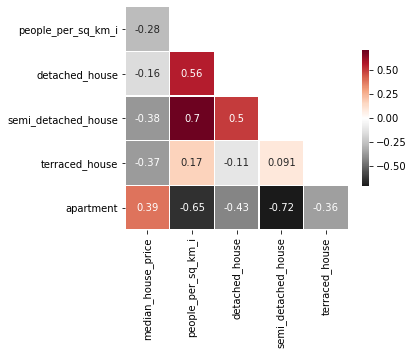

In [59]:
correlations_heatmap(housing)

All indicators seem quite correlated to each other to a certain extent. `median_housing_price` is negatively correlated to most other indicators. We can already learn from this heatmap that when median price is high, the density of people and the number of semi-detached and terraced houses goes down, but that the number of detached houses and apartements goes up. So we can link high housing cost to apartement and detached houses. This is indeed quite representative of London housing market, where it is much cheaper to live in suburbs. There is mostly appartements in city center, where it is extremely expensive to buy an appartement.

The problem now is that this indicator is supposed to give an idea of housing conditions, is it better to have an appartement? or better to have a house ?. Looking back at [housing](#house), we don't really need to include what type of housing areas have more. So we will remove them from the indicator, keeping only `people_per_sq_km`and '`median_house_price`.

In [60]:
housing  = housing.drop(columns = ['detached_house', 'semi_detached_house', 'terraced_house', 'apartment'], axis = 1)

Let's now compute the weights of the two remaining sub-indicators, and use them to compute the housing index, or what quality of housing people have: 

In [61]:
housing_weights = calculate_weights(housing)
housing_index = calculate_index_for_df(housing,housing_weights )

# Create a df to store the indexes 
ALDI = pd.DataFrame(housing_index)
ALDI = ALDI.rename(columns={'i' : 'Housing'})

housing_weights

Component cumulative variance: 63.91193342401199 %
Component cumulative variance: 100.0 %
Explained var [0.0, 1.414213562373095]
Eigenvalues [1.27823867 0.72176133]


,weights
median_house_price,0.69275
people_per_sq_km_i,0.69275


### Weights for environment. <a class="anchor" id="env_w"></a>

Let's have a look at the heatmap of correlations for the environement sub-indicator

[Back to index](#weights1)

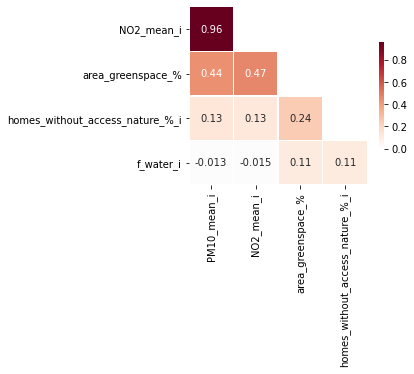

In [62]:
correlations_heatmap(environment)

The 2 indicators for air pollution are very correlated to each other,and both are correlated relatively strongly to `area_greenspace_%`, this not only indicates that they both indicate the same thing, but that they are also related to a certain extent to how much green space their is (negatively correlated that is when we remember that we [inversed](#env) that variable). We can thus expect them to have quite small weights.

In [63]:
environment_weights = calculate_weights(environment)
environment_index = calculate_index_for_df(environment,environment_weights )
ALDI = ALDI.assign(Environment = environment_index.i)
environment_weights

Component cumulative variance: 46.88075386992207 %
Component cumulative variance: 69.59158111053031 %
Component cumulative variance: 86.99882785724355 %
Component cumulative variance: 99.28688649200295 %
Explained var [-1.9254597772607163, -1.118342834618494, 0.13877361145420675, -0.15047266625445274]
Eigenvalues [2.34403769 1.13554136 0.87036234 0.61440293 0.03565568]


,weights
PM10_mean_i,0.158712
NO2_mean_i,0.161221
area_greenspace_%,1.198375
homes_without_access_nature_%_i,0.592430
f_water_i,0.523992


Indeed `PM10_mean` and `NO2_mean` have very small weigths compared to the other sub_indicators. It could create a problem, these air pollution indicators might not be taken into account with these small weights. In reality the subsequent histogram shows us why this isn't such a problem. 

We can see that lots of areas have a positive relative variable distribution, the variable being inversed, this means all those areas have quite good air quality. and will have a small score boost (due to a combination of having a slightly positive value and a small weight for those variables). In contrast a small number of areas have a very bad air quality (on the left of the graph), and thus will be quite strongly penalized (big negative value but still small weight).

Another example is with `homes_without_access_nature_%`, we see that most areas have a small percentage of homes without access to nature (again let's not forget that this data was inversed). So they have a relatively small score boost, but the ares that have a big percent of homes without access to nature get penalized  strongly. 

Finally `area_greenpace_%` has a relatively small number of areas with a high percentage of greenspace (right of graph), these areas are stronly boosted (relative positive score and large weight), but the others, which have a small percent of greenspaces, will be penalized quite strongly (but not too much, as they have a relatively small negative score).

All this tedious explanation shows us that the PCA model is really quite robust, it takes into account how variables are correlated together, thus avoiding double counting, while also mitigating for skewed data. In addition inversing the variables seems to give us the intended purpose.

Here `f_water` was omitted from the graph because its ditribution is more homogenous, and made it difficult to read the graph. 



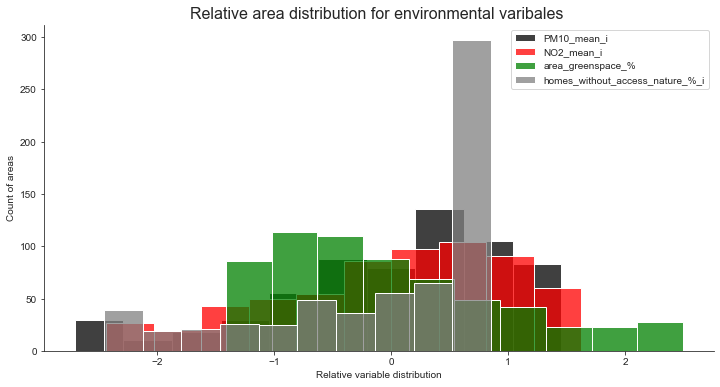

In [64]:
plt.figure(figsize=(12,6))
sns.set_style('ticks')
c = [ 'black','red', 'green', 'grey','lightblue']

for i, col in enumerate(['PM10_mean_i','NO2_mean_i', 'area_greenspace_%', 'homes_without_access_nature_%_i']):
    ax = sns.histplot(environment[col], label =col,color = c[i], bins=10)

ax.set_title('Relative area distribution for environmental varibales ', fontsize=16);
ax.set(xlabel='Relative variable distribution', ylabel = 'Count of areas')
sns.despine()
plt.legend()
plt.show()

### Let's look at another sub-indicator now, safety. <a class="anchor" id="safety_w"></a>


[Back to index](#weights1)

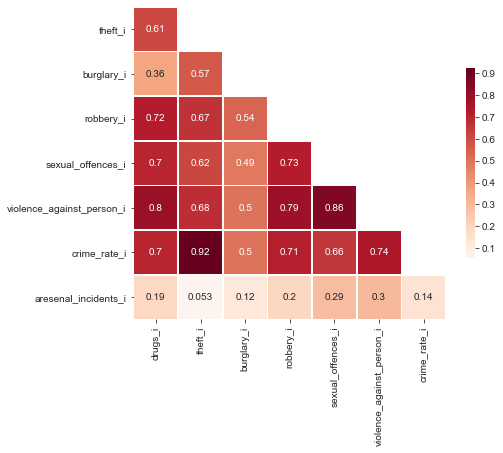

Component cumulative variance: 63.40004999127052 %
Component cumulative variance: 76.32035493474255 %
Component cumulative variance: 84.97626392968236 %
Component cumulative variance: 91.12037402256517 %
Component cumulative variance: 94.68784867335708 %
Component cumulative variance: 97.75987796632627 %
Explained var [-2.7342758558315006, -0.5673957003729861, 0.37808160698002014, -0.15822622501669997, -0.11899634374635672, 0.08887992641667113]
Eigenvalues [5.072004   1.0336244  0.69247272 0.49152881 0.28539797 0.24576234
 0.11822058 0.06098919]


,weights
drugs_i,1.427392
theft_i,0.577910
burglary_i,1.028254
robbery_i,2.319386
sexual_offences_i,1.675005
violence_against_person_i,0.142718
crime_rate_i,0.561606
aresenal_incidents_i,0.775229


In [65]:
correlations_heatmap(safety)
safety_weights = calculate_weights(safety)
safety_index = calculate_index_for_df(safety,safety_weights )
ALDI = ALDI.assign(Safety = safety_index.i)

safety_weights

Here all sub-indicators of safety are strongly correlated save for one. This not-so-correlated sub-indicator, `arsenal_incident`, does not get a particularly high weight as one could expect. We must not forget that the heatmap above only shows first order correlations, so maybe arsenal incidents aren't that correlated with other variables, but are with combinations of other variables. 

### Weigths for income, life satisaction, civic engagement and work-life balance <a class="anchor" id="safety_w"></a><a class="anchor" id="civic_w"></a> <a class="anchor" id="satisfaction_w"></a> <a class="anchor" id="balance_w"></a>


These categories all have only sub-indicator, so no need to do any pca analysis. 


[Back to index](#weights1)

In [66]:
for cat in ['Income', 'Life_Satisfaction', 'Civic','Work_Life_Balance'] :
    ALDI = ALDI.merge(meta_data_indicators[cat],on='area_id', how='inner')
ALDI =  ALDI.rename(columns={'median_income' : 'Income', 'how_satisfied_are_you_score' : 'Life_Satisfaction', 
                                   'election_turnout' : 'Civic', 'part_time_employee_percent' : 'Work_Life_Balance' })


### Weigths for jobs, education, community, health and alcohol <a class="anchor" id="jobs_w"></a><a class="anchor" id="community_w"></a> <a class="anchor" id="health_w"></a> <a class="anchor" id="alcohol_w"></a>


These indicators all have quite few sub-indicators, so we will perform pca on them, and add the indexes to `ALDI`, without further anylysis.

[Back to index](#weights1)


Heatmap of correlations for Jobs


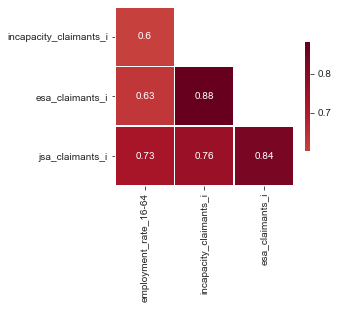

PCA for Jobs
Component cumulative variance: 80.69299167227983 %
Component cumulative variance: 92.39220446031656 %
Component cumulative variance: 97.48988283359293 %
Explained var [-1.9969911021059712, -0.0954015350831001, -0.05364908713600891]
Eigenvalues [3.22771967 0.46796851 0.20390713 0.10040469]
                         weights
employment_rate_16-64   1.432175
incapacity_claimants_i  1.370713
esa_claimants_i         0.280131
jsa_claimants_i         2.958712

Heatmap of correlations for Community


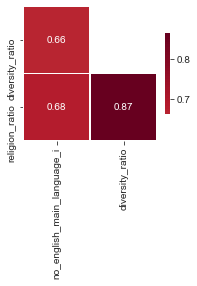

PCA for Community
Component cumulative variance: 82.52592227524171 %
Component cumulative variance: 95.57066192121026 %
Explained var [1.7303341153990333, -0.07671460336603142]
Eigenvalues [2.47577767 0.39134219 0.13288014]
                             weights
no_english_main_language_i  1.805874
diversity_ratio             0.427757
religion_ratio              0.321677

Heatmap of correlations for Education


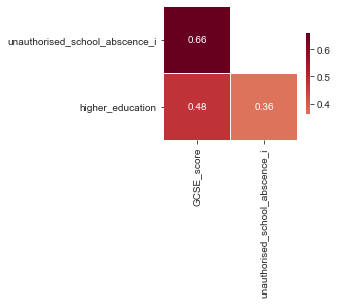

PCA for Education
Component cumulative variance: 67.03908692889934 %
Component cumulative variance: 89.25895348947344 %
Component cumulative variance: 100.0 %
Explained var [1.7255651126875913, 0.1309016363086034, 0.07273103524073932]
Eigenvalues [2.01117261 0.666596   0.3222314 ]
                                 weights
GCSE_score                      1.754763
unauthorised_school_abscence_i  1.230631
higher_education                1.056547

Heatmap of correlations for Health


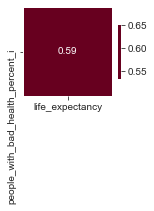

PCA for Health
Component cumulative variance: 79.61168468308594 %
Component cumulative variance: 100.0 %
Explained var [-1.414213562373095, -1.1102230246251565e-16]
Eigenvalues [1.59223369 0.40776631]
                                   weights
life_expectancy                   1.226193
people_with_bad_health_percent_i  1.226193

Heatmap of correlations for Alcohol


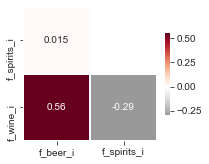

PCA for Alcohol
Component cumulative variance: 54.03821865099046 %
Component cumulative variance: 87.77864127979531 %
Component cumulative variance: 100.00000000000001 %
Explained var [-1.0198896413695333, -1.3363938591027729, 0.41698509898978925]
Eigenvalues [1.62114656 1.01221268 0.36664076]
              weights
f_beer_i     1.065101
f_spirits_i  0.774815
f_wine_i     1.350217


In [67]:
for cat in ['Jobs','Community','Education', 'Health','Alcohol']:
    print('\nHeatmap of correlations for', cat)
    correlations_heatmap(meta_data_indicators[cat])
    print('PCA for', cat)
    weights = calculate_weights(meta_data_indicators[cat])
    index = calculate_index_for_df(meta_data_indicators[cat],weights )
    ALDI = ALDI.assign(new = index.i)
    ALDI =  ALDI.rename(columns={'new' : cat})
    print(weights)

Side note : funny how s`f_wine`negatively correlates with `f_spirits`, while `f_beer` barely correlates with `fspirits`. It could be interesting to see which areas have these alcohol preferences. 

### And finally let's compute the weigths for the food indicator. <a class="anchor" id="food_w"></a>

We will have a look at how they all are correlated together, this is by far the largest amount of sub_indicators we have for on indicator.

[Back to index](#weights1)

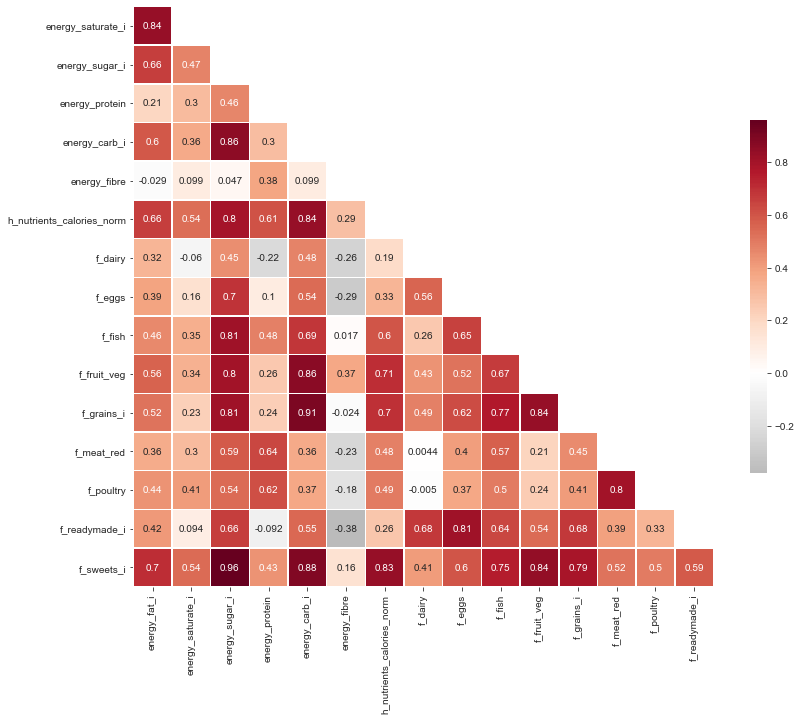

In [68]:
correlations_heatmap(foods)

This simple heatmap shows us a lot about general nutrition. Fibers are mainly in fruits and vegetables, as higlighted by the relatively strong correlation between `energy_fibre` and `f_fruit_veg` (one of the highest categories energy_fiber correlates with). Suprising to see that `f_readymade_i` correlates negatively with `energy_fibre`, meaning that because we inversed the first variable, they actually correlate positively ! Also areas that buy a larger fraction of sweets also get a lot of energy from fats. We can compute the weights as nothing seems really out of the ordinary

In [69]:
foods_weights = calculate_weights(foods)
foods_index = calculate_index_for_df(foods, foods_weights)
ALDI = ALDI.assign(new = foods_index.i)
ALDI =  ALDI.rename(columns={'new' : 'Foods'})
foods_weights

Component cumulative variance: 52.69466230361667 %
Component cumulative variance: 68.19320621412426 %
Component cumulative variance: 79.38762548463393 %
Component cumulative variance: 87.00202202397482 %
Component cumulative variance: 90.31212516941713 %
Component cumulative variance: 93.08917728041435 %
Component cumulative variance: 94.79884662534435 %
Component cumulative variance: 96.22913004517785 %
Explained var [-3.7864950180411627, -0.4432771276068529, 0.16610626350591637, 0.08613003837713364, 0.25904491435418037, -0.8378644500133139, 0.3975062466932233, -0.17161831635887526]
Eigenvalues [8.43114597 2.47976703 1.79110708 1.21830345 0.5296165  0.44432834
 0.2735471  0.22884535 0.19265268 0.13392043 0.09807809 0.06459413
 0.04416915 0.02957921 0.02177824 0.01856726]


,weights
energy_fat_i,0.269015
energy_saturate_i,0.330126
energy_sugar_i,0.080905
energy_protein,0.314039
energy_carb_i,0.195039
energy_fibre,0.438432
h_nutrients_calories_norm,0.317346
f_dairy,0.909633
f_eggs,1.782477
f_fish,0.795366


## Computing the weights for the indicators <a class="anchor" id="weights2"></a>

Finally we can compute the weights for the indicators, to then have a final score for each area, that will allow us to see wich one has the best living standards.

[Back to index](#3-bullet)

In [70]:
# The ALDI dataframe, containing all the variables per category for each area.
ALDI.head(10)

,area_id,Names,Housing,Environment,Safety,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Health,Alcohol,Foods
0,E05000029,Chadwell Heath,0.168402,0.514777,0.520392,-0.757899,-1.745599,-0.085885,1.438589,-3.765104,1.699613,-6.512482,-2.551708,1.624190,-3.159135
1,E05000042,Whalebone,-0.426852,-2.863299,1.089691,-0.276057,0.220689,0.341079,0.136017,0.489528,1.217960,-2.728190,0.854396,0.557317,-4.662427
2,E05000030,Eastbrook,0.155654,1.914902,3.187532,-0.243540,0.876118,0.158095,-1.469544,-2.851769,2.825330,-3.929616,-2.548363,2.303641,-3.100921
3,E05000034,Heath,-0.279673,-1.319790,-2.392262,-1.139234,-0.434740,-0.467103,1.961080,-6.450753,2.104989,-4.400535,-3.758060,2.294665,-10.869352
4,E05000040,Valence,-0.619709,-2.246098,2.881807,-0.864318,-0.434740,-0.695834,1.438589,-1.754673,1.844261,-5.794414,-4.500602,3.243790,-5.862122
5,E05000037,Parsloes,-0.685017,-0.943398,5.918678,-1.062376,1.859262,-0.634839,2.174826,-6.323107,2.130521,-3.513276,-3.367835,1.479039,0.641682
6,E05000028,Becontree,-0.979531,-2.273079,-1.380825,-0.893879,-0.107026,-0.268870,2.174826,-5.008469,0.723057,-5.963321,-3.664406,1.854074,2.787852
7,E05000036,Mayesbrook,-0.294816,1.921595,4.808231,-1.111151,-0.107026,-0.375611,2.174826,-5.384638,1.730065,-4.484913,-3.209515,1.146445,-2.802365
8,E05000027,Alibon,-0.583679,-1.849365,2.141567,-0.972215,-0.762455,-0.421357,2.174826,-5.092772,1.982145,-5.076263,-3.473753,1.258609,-4.734298
9,E05000041,Village,-0.207796,1.938852,-1.991794,-1.047596,-1.745599,-0.451855,1.070471,-3.119679,1.737213,-5.498739,-3.149309,3.396094,-1.417662


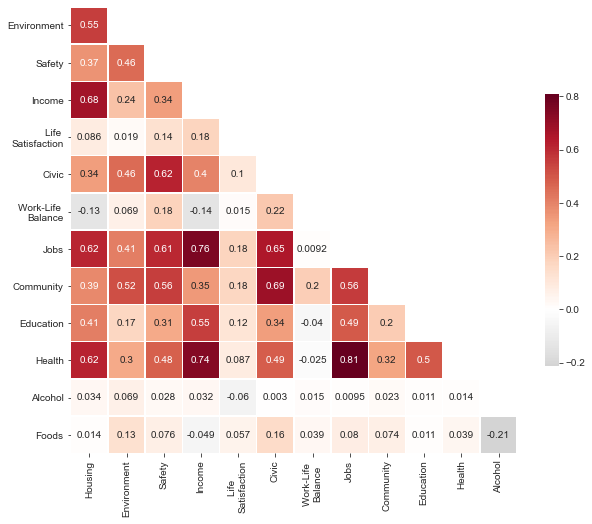

In [71]:
correlations_heatmap(ALDI.rename(columns = {'Life_Satisfaction' : 'Life \nSatisfaction', 'Work_Life_Balance' : 'Work-Life \nBalance'}),export_map = 'ALDI_correlations')

In [72]:
# We have a few nan values that we didn't remove at the start, otherwise we would have lost all data to that area while merging
# We will remove them now, by approximating their values to the mean of the indicator.
ALDI.isna().sum()

area_id              0
Names                0
Housing              0
Environment          0
Safety               0
Income               0
Life_Satisfaction    0
Civic                0
Work_Life_Balance    2
Jobs                 0
Community            0
Education            1
Health               0
Alcohol              0
Foods                0
dtype: int64

In [73]:
ALDI.Education = ALDI.Education.fillna(ALDI.Education.mean())
ALDI.Work_Life_Balance = ALDI.Work_Life_Balance.fillna(ALDI.Work_Life_Balance.mean())

We normalize all the variables, so that we can compare them more easily, and that the weigths are easier to interpret. Then we can compute the weights and the final index.

In [74]:
ALDI = normalize(ALDI, norm, remove_outliers = False)
final_weigths = calculate_weights(ALDI)
final_index = calculate_index_for_df(ALDI, final_weigths)
ALDI = ALDI.assign(final = final_index.i)
final_weigths

Component cumulative variance: 38.17401651558504 %
Component cumulative variance: 50.62743520882675 %
Component cumulative variance: 60.0347579976615 %
Component cumulative variance: 67.92282030188183 %
Component cumulative variance: 74.8450799813195 %
Component cumulative variance: 80.69342383913185 %
Component cumulative variance: 85.61341293275447 %
Component cumulative variance: 89.98145481433204 %
Component cumulative variance: 93.61872651588992 %
Component cumulative variance: 95.90651181823759 %
Explained var [3.13732515283692, -0.7097325169715174, 0.11587104106716861, -0.5202672231529948, 0.3195388851169655, -1.3334380028204393, 0.6698545106140843, 0.008610590932861636, 0.03287126578619144, 0.12459852413786321]
Eigenvalues [4.96262215 1.61894443 1.22295196 1.0254481  0.89989376 0.7602847
 0.63959858 0.56784544 0.47284532 0.29741209 0.21655314 0.18843312
 0.1271672 ]


,weights
Housing,0.310583
Environment,0.529234
Safety,1.131941
Income,0.120384
Life_Satisfaction,0.461276
Civic,0.831167
Work_Life_Balance,0.565590
Jobs,0.105616
Community,0.596468
Education,1.149813


In [75]:
# We normalize the final index so that they are all between 0 and 1
ALDI.loc[:, ['area_id', 'final']] = normalize(ALDI.loc[:, ['area_id', 'final']],method = 're_scale', remove_outliers = False)
ALDI.head(3)

,area_id,Names,Housing,Environment,Safety,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Health,Alcohol,Foods,final
0,E05000029,Chadwell Heath,0.202330,0.292055,0.076969,-0.757899,-1.745599,-0.085885,1.440875,-0.686894,0.718378,-1.940717,-1.166149,0.759747,-0.585088,0.361376
1,E05000042,Whalebone,-0.512848,-1.624471,0.161172,-0.276057,0.220689,0.341079,0.136233,0.089308,0.514797,-0.813000,0.390465,0.260696,-0.863506,0.397788
2,E05000030,Eastbrook,0.187013,1.086405,0.471456,-0.243540,0.876118,0.158095,-1.471879,-0.520268,1.194186,-1.171024,-1.164620,1.077573,-0.574307,0.460836


In [76]:
#Store the results
ALDI.to_csv('output/ALDI_'+norm+'.csv', index=False)
final_weigths.to_csv('output/weights_'+norm+'.csv', index=True)

## 4. Map <a class="anchor" id="map"></a>

Let's plot the data on a map. We will need additional librairies : 
* geopandas : https://geopandas.org/install.html
* descartes : https://docs.descarteslabs.com/installation.html

The following was heavily inspired from this tutorial : https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

Additional data for the map creation : https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

[Back to index](#3-bullet)

In [77]:
import geopandas as gpd

In [78]:
#Need to import some data frames for the map
map_wards = gpd.read_file("data/London-wards-2018_ESRI")
geo = pd.read_csv("data/london_pcd2geo_2015.csv")
map_boroughs = gpd.read_file('data/statistical-gis-boundaries-london/ESRI')

In [79]:
# Preparing some dataframes and functions for convenient plotting/aggregating
geo = geo[['oslaua','osward']].drop_duplicates() 
geo_boroughs = map_boroughs.merge(geo, right_on = 'oslaua',left_on = 'GSS_CODE')

def aggregate_to_borough(df, col, on = 'GSS_CODE'):
    res = df.merge(geo, on = 'osward')
    res.loc[:,col] = res.apply(lambda x : np.sum(res[x.loc[on] == res.loc[:,on]].loc[:,col]) 
                                               / np.sum([x.loc[on] == res.loc[:,on]]), axis =1)
    return res

def plot_map(df, col, level = 'ward', export_map = False) :
    fig, ax = plt.subplots(1, figsize=(25, 20))
    
    if level == 'ward' :
        merged_wards = map_wards.set_index('GSS_CODE').join(df.set_index('area_id'))
        # plot the map
        merged_wards.plot(column=col, cmap=colors, linewidth=0.8, ax=ax, edgecolor='0.8')
    elif level == 'borough' :
        merged_boroughs = geo_boroughs.merge(df.loc[:,['area_id', col]],left_on = 'osward', right_on = 'area_id')
        merged_boroughs = aggregate_to_borough(merged_boroughs,col)
        
        # plot the map and show the borough names
        merged_boroughs.plot(column=col, cmap=colors, linewidth=0.8, ax=ax, edgecolor='0.8')
        merged_boroughs.apply(lambda i : ax.annotate(i.NAME, xy=i.geometry.centroid.coords[0], 
                                                     xytext=(3, 3), textcoords="offset points", 
                                                     backgroundcolor = 'white', ha = 'center', fontsize = 9), axis = 1)
    
    plt.title('ALDI scores for London Greater Area', fontsize = 20)
    
    vmin, vmax = df.loc[:,col].min(), df.loc[:,col].max()
    sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # add the colorbar to the figure
    cbar = fig.colorbar(sm,shrink =  .3,drawedges = False)
    cbar.outline.set_visible(False)
   
    ax.axis('off')
    
    #python is magic, if a string is passed in export_map, will be used to save the figure
    if export_map : fig.savefig('output/'+export_map+'.png') 

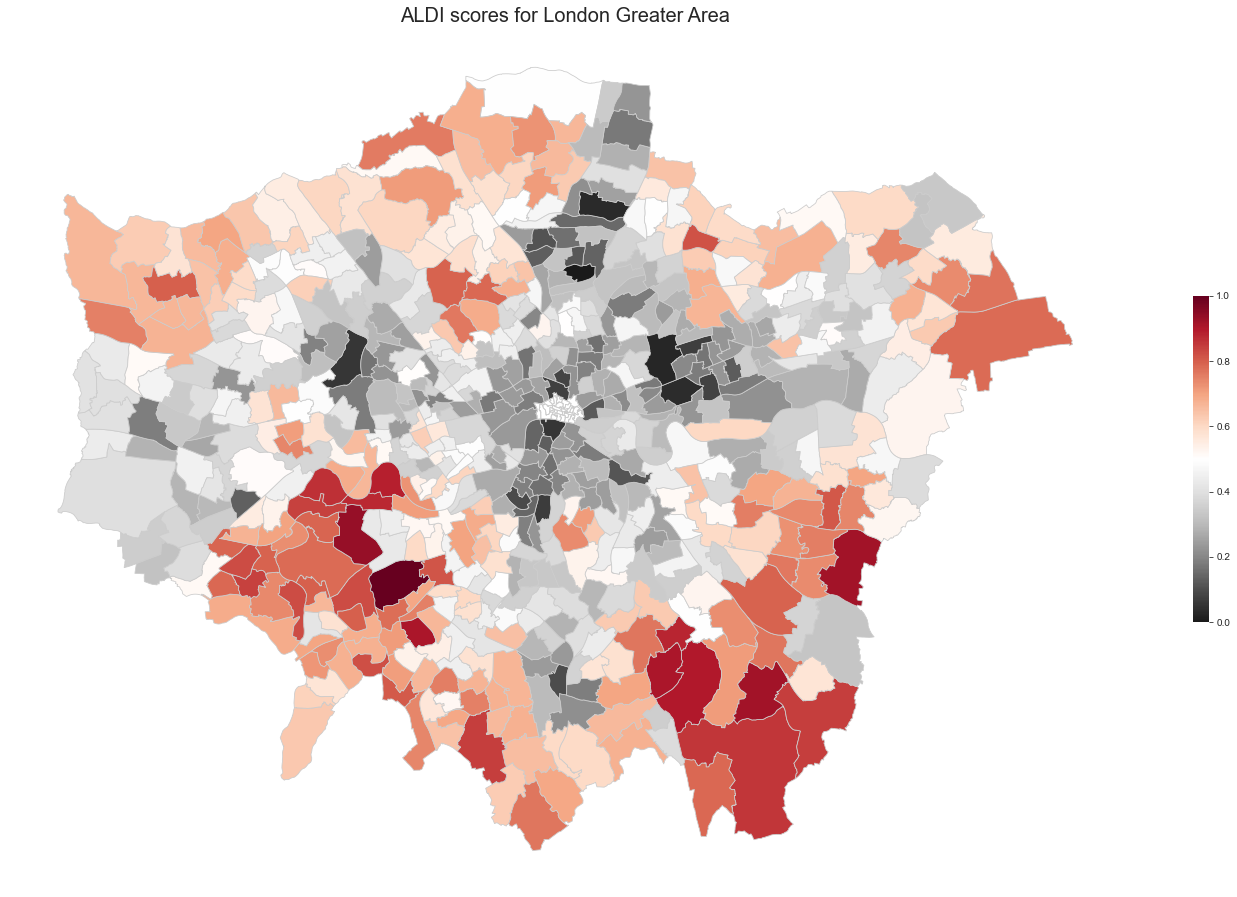

In [80]:
plot_map(ALDI, col = 'final', export_map = 'ALDI_ward_map' )

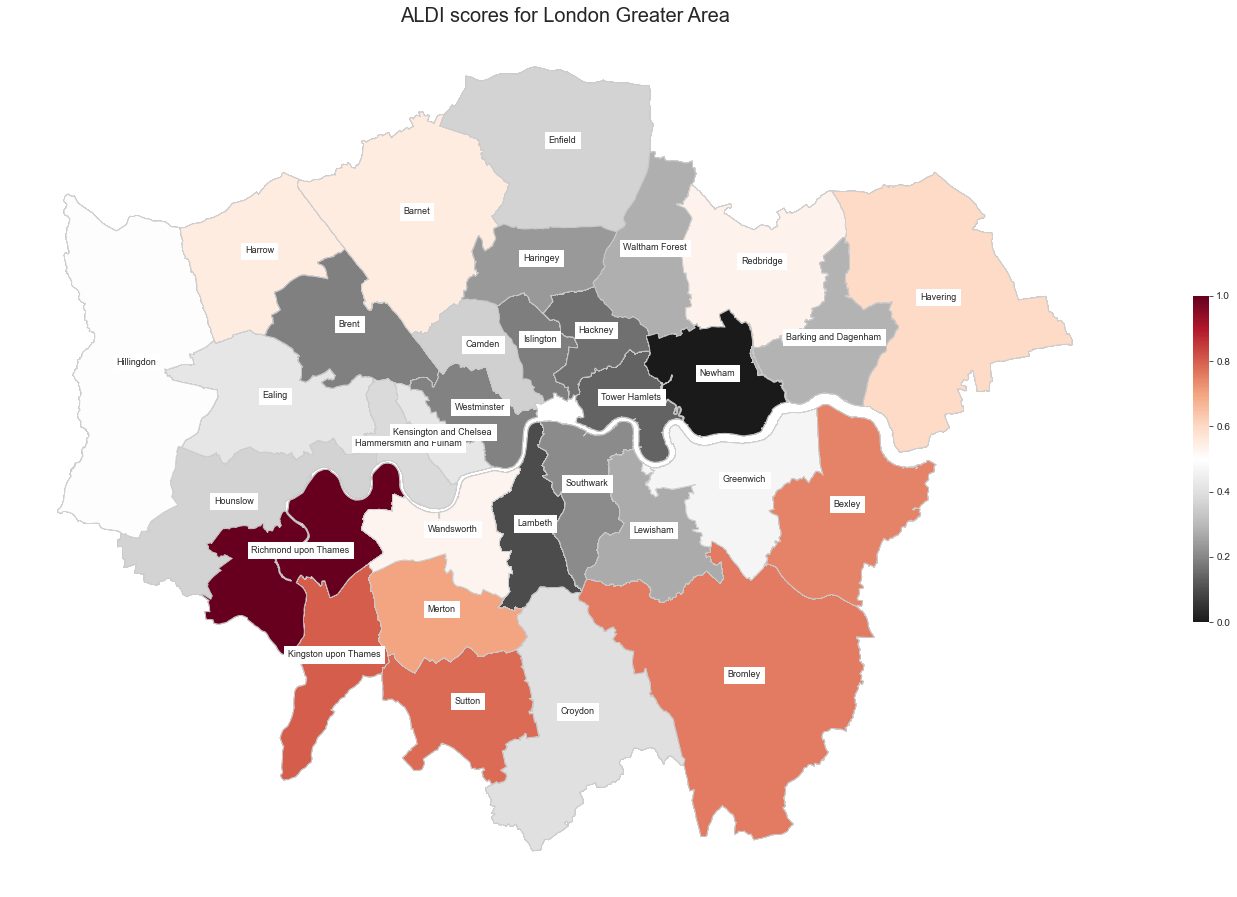

In [81]:
plot_map(ALDI, col = 'final', level = 'borough', export_map = 'ALDI_borough_map')

## 5. Validation <a class="anchor" id="validation"></a>

We will try to validate the best we can our results, this will be quite difficult as there is no perfect index that measures life quality in an independent manner.

We will compare the 2 methods of normalisation and corrleate them to the wellbeing [dataset] (https://data.london.gov.uk/dataset/subjective-personal-well-being-borough). We first have to aggregate it at the borough level though, as we don't have data at ward level.

[Back to index](#3-bullet)

In [82]:
# Load the results that were obtained with the two normlalisation methods.
ALDI_standardization = pd.read_csv('output/ALDI_standardize.csv')
ALDI_re_scale = pd.read_csv('output/ALDI_re_scale.csv')

In [83]:
# Aggregate our results to bourough level to correlate with wellbeing dataframe

val = aggregate_to_borough(ALDI_standardization.loc[:,['area_id', 'final']].merge(geo, left_on = 'area_id', right_on = 'osward'), 'final', on = 'oslaua_x')
val = aggregate_to_borough(ALDI_re_scale.loc[:,['area_id', 'final']].merge(val, left_on = 'area_id', right_on = 'osward'), 'final_x', on = 'oslaua_x')
val = val.loc[:,['oslaua_x','final_x', 'final_y']].drop_duplicates()
val = val.merge(wellbeing, right_on = 'Code', left_on = 'oslaua_x')
val = val.rename(columns = {'oslaua_x':'area_id', 'final_y' : 'final_std', 'final_x' : 'final_re_scale'})
val = val.drop(columns = 'Code')

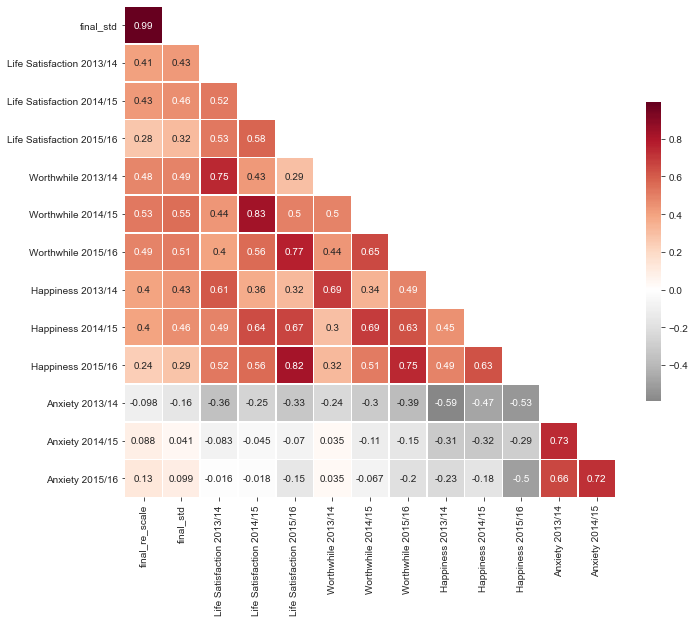

In [84]:
val_corr = correlations_heatmap(val,True)

We see that we correlate quite well with this validation dataset, of course we aimed to have something a bit more indicative than simple self-reported data. Indeed this `wellbeing` dataset was constructed by asking questions to people in the manner of 'How happy where you yesterday?' or 'How worthwhile do you feel'. It is still quite a good thing that we correlated to some extent with these answers, but knowing that we take into account more objective variables (food, health, safety..), we have somewhat succeeded in creating an Advanced Life Developpement Index.

We don't correlate that well with anxiety (which isn't a 'good' thing, so the more negative the correlation the better), which could be investigated in a furhter project.

Last thing to do is to see which normalization method correlates best with this validation dataset. We see below that standardization correlates overall slightly better, but both normalization methods yield basically the same result, as they are strongly correlated. We stuck with standardization for the analysis (as you may have realized), because it induces less distortion and is the prefered method for PCA. (see this [reference, page 18](https://publications.jrc.ec.europa.eu/repository/bitstream/JRC31473/EUR%2021682%20EN.pdf))

In [85]:
print('Sum of correlations for ALDI calculated using re-scaling normalization:\t\t', sum(np.abs(val_corr.final_re_scale)),
      '\nSum of correlations for ALDI calculated using standardization normalization:\t', sum(np.abs(val_corr.final_std)))


Sum of correlations for ALDI calculated using re-scaling normalization:		 4.952669624666988 
Sum of correlations for ALDI calculated using standardization normalization:	 5.237257289239162


## 6. Figures <a class="anchor" id="figures"></a>

Here we create a few different plots to explore the different categories. Mainly for the [DataStory](https://charlyneburki.github.io/The-ALDI/).

[Back to index](#index)

First up, we are exploring and plotting the Foods Category:

In [86]:
foods_copy.rename(columns={'f_dairy':'dairy', 'f_eggs':'eggs', 'f_fish':'fish', 'f_fruit_veg':'fruits & vegetables',
                'f_grains':'grains', 'f_meat_red':'red meat', 'f_poultry':'poultry', 'f_readymade':'ready-made', 
                           'f_sweets':'sweets'},inplace=True)

melted_food = pd.melt(foods_copy,id_vars=['area_id','energy_carb', 'h_nutrients_calories_norm'], var_name='food type', 
                      value_vars=['eggs','poultry', 'fish','red meat', 'ready-made', 'dairy',
                'grains' , 'sweets', 'fruits & vegetables'] )

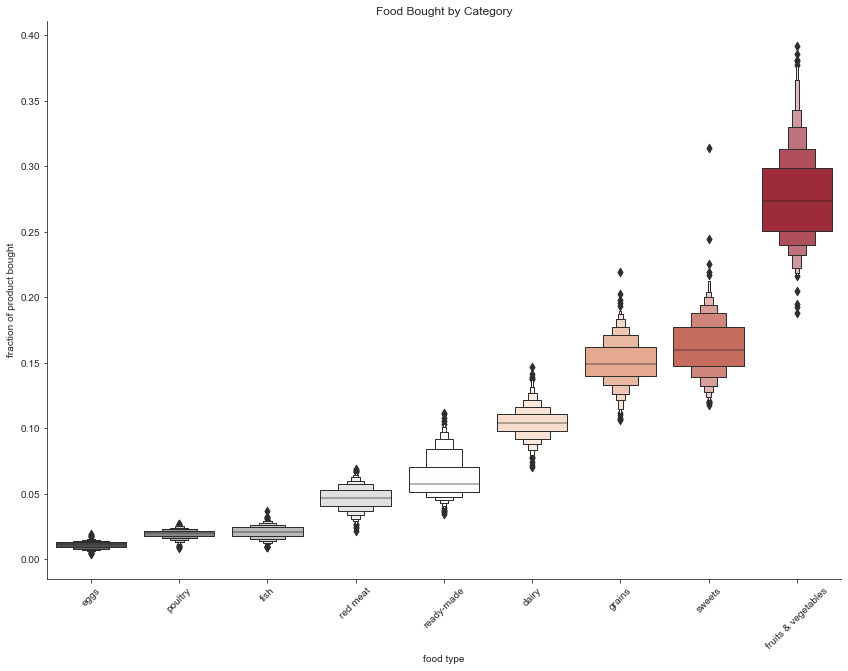

<Figure size 432x288 with 0 Axes>

In [87]:
sns_plot = sns.catplot(x='food type', y='value', data=melted_food, kind='boxen', palette='RdGy_r', aspect=11.7/8.27, height=8.27)
plt.ylabel('fraction of product bought')
plt.xticks(rotation=45)
plt.title('Food Bought by Category')
plt.show()
sns.despine()
sns_plot.savefig('output/exploring_foods.png')

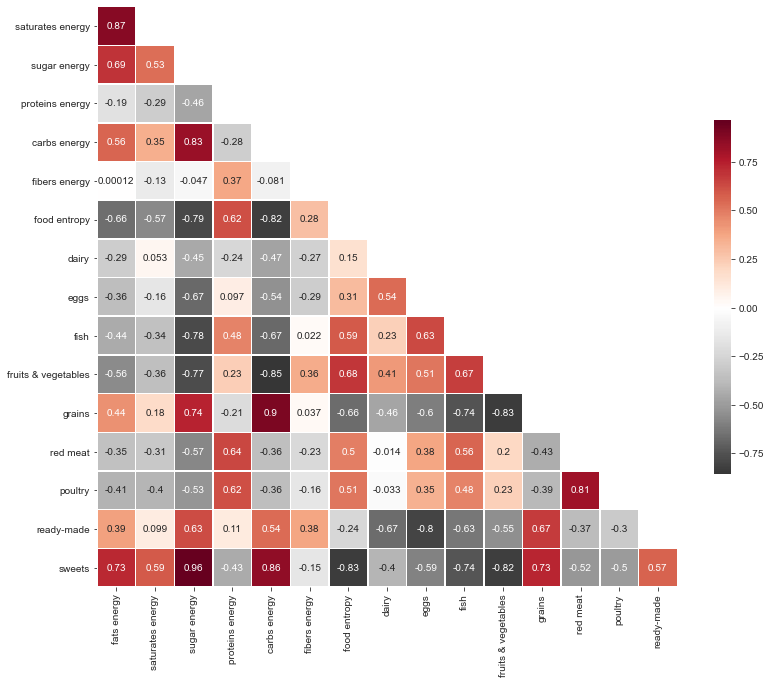

In [88]:
correlations_heatmap(foods_copy.rename(columns = {'f_dairy':'dairy', 'f_eggs':'eggs', 'f_fish':'fish', 'f_fruit_veg':'fruits & veggies',
                'f_grains':'grains', 'f_meat_red':'red meat', 'f_poultry':'poultry', 'f_readymade':'ready-made', 
                           'f_sweets':'sweets', 'energy_fat':'fats energy','energy_saturate': 'saturates energy', 
                   'energy_sugar': 'sugar energy','energy_protein': 'proteins energy','energy_carb': 'carbs energy',
                'energy_fibre':'fibers energy','h_nutrients_calories_norm':'food entropy'}), export_map ='foods_correlation')

Next, we explore the Environment Category and create an interesting pannel of the raw data:

/Users/charlyne/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


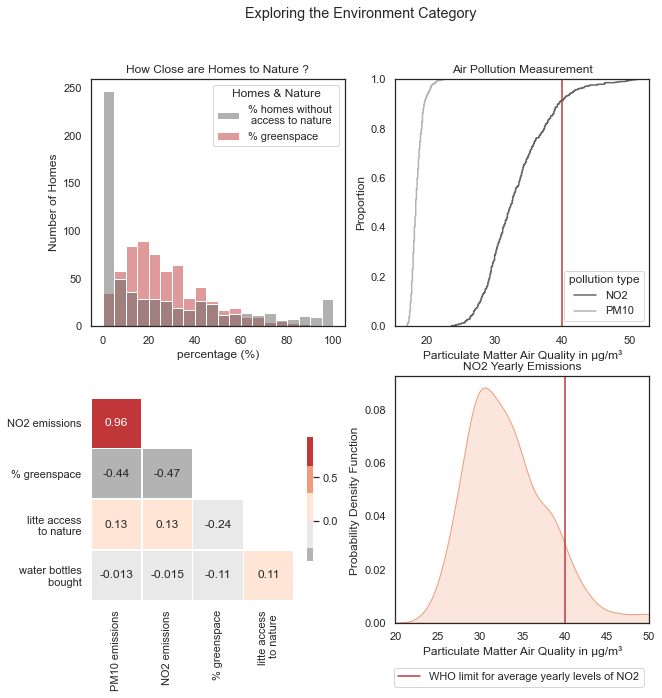

In [89]:
sns.set_theme(style="white")
sns.set_palette('RdGy')
colors_r =sns.color_palette('RdGy')

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")


fig, axes = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Exploring the Environment Category')

#First plot
palette = {'% homes without \n access to nature':colors_r[5],'% greenspace':colors_r[0]}

env_copy.rename(columns={'homes_without_access_nature_%':'% homes without \n access to nature', 
                         'area_greenspace_%':'% greenspace'},inplace=True)

melted_env = pd.melt(env_copy, id_vars=['area_id'], var_name='Homes & Nature',
                     value_vars=['% homes without \n access to nature','% greenspace'])

axes[0,0].set_title('How Close are Homes to Nature ?')
sns.histplot(melted_env, x='value', hue='Homes & Nature', palette=palette, bins=20, ax=axes[0,0])
axes[0,0].set(xlabel='percentage (%)', ylabel='Number of Homes')

#second plot
sns.set_palette('RdGy_r')
env_copy.rename(columns={'NO2_mean':'NO2', 'PM10_mean':'PM10'}, inplace=True)
melted_env = pd.melt(env_copy, id_vars=['area_id'], var_name='pollution type', value_vars=['NO2','PM10'])


axes[0,1].set_title('Air Pollution Measurement')
axes[0,1].axvline(40, color = colors_r[0], label='WHO limit for average yearly levels of pollution')
sns.ecdfplot(data=melted_env, x='value', hue='pollution type', ax=axes[0,1],color=colors_r, legend=True)
axes[0,1].set(xlabel='Particulate Matter Air Quality in \u03BCg/'+"m3".translate(SUP))
plt.xlim(20, 50)


#third plot
axes[1,1].set_title('NO2 Yearly Emissions')
sns.kdeplot(data=env_copy, x='NO2', fill=True, color=colors_r[1],ax = axes[1,1])
axes[1,1].set(xlabel='Particulate Matter Air Quality in \u03BCg/'+"m3".translate(SUP), ylabel = 'Probability Density Function ')
axes[1,1].axvline(40, color = colors_r[0], label='WHO limit for average yearly levels of NO2')
lgd = axes[1,1].legend(bbox_to_anchor=(1, -0.16))
plt.xlim(20, 50)

#fourth plot 
c =sns.color_palette('RdGy_r')
df = meta_data_indicators['Environment']

X = df.loc[:, df.columns != 'area_id']
if 'Names' in X.columns:
    X = X.loc[:, X.columns != 'Names']
n = round(X.shape[1]/1.3)
correlations = inverse(X, ['NO2_mean_i', 'PM10_mean_i','homes_without_access_nature_%_i', 'f_water_i']).corr()
df.rename(columns={'NO2_mean_i_i':'NO2 emissions', 'PM10_mean_i_i':'PM10 emissions', 'area_greenspace_%':'% greenspace',
                 'homes_without_access_nature_%_i_i': 'litte access to nature', 'f_water_i_i':'water bottles bought'},inplace=True)   

correlations = correlations.drop(correlations.index[0])
correlations = correlations.drop(correlations.columns[correlations.shape[1]-1],axis = 1)
    
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False
#fig, ax = plt.subplots(figsize=(n,n)) 
correlations = correlations.rename(index={'NO2_mean_i_i':'NO2 emissions', 'PM10_mean_i_i':'PM10 emissions', 'area_greenspace_%':'% greenspace',
                 'homes_without_access_nature_%_i_i': 'litte access\n to nature', 'f_water_i_i':'water bottles\n bought'},
                                  columns = {'NO2_mean_i_i':'NO2 emissions', 'PM10_mean_i_i':'PM10 emissions', 'area_greenspace_%':'% greenspace',
                 'homes_without_access_nature_%_i_i': 'litte access\n to nature', 'f_water_i_i':'water bottles\n bought'})
sns.heatmap(correlations,mask=mask, annot=True, cmap = c,
                center = 0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax= axes[1,0])

plt.show()
fig.savefig('output/exploring_env')

And we create a graph showcasing the weights we chose for the map 

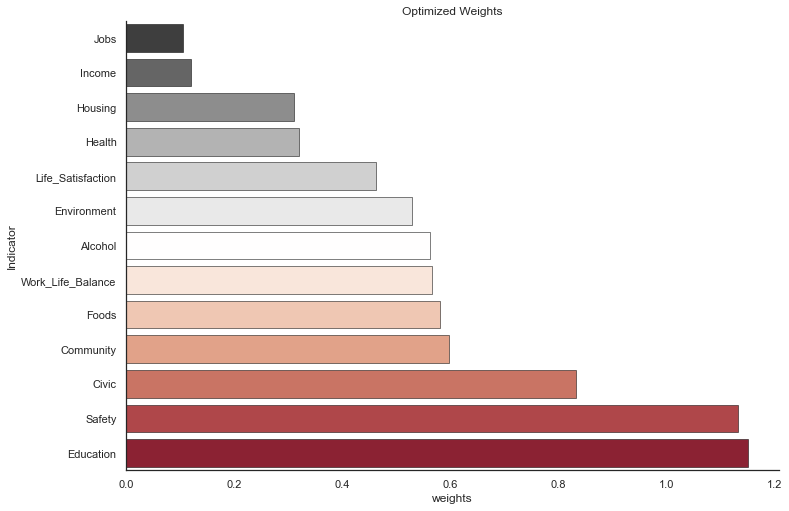

In [90]:
#Create a graph with weights 
weights = pd.read_csv('output/weights_standardize')
weights = weights.rename(columns = {'Unnamed: 0':'Indicator'})

sns.set_theme(style="white")
sns.set_palette('RdGy')
fig, ax = plt.subplots(figsize=(11.7, 8.27))
ax = sns.barplot(x="weights",y = 'Indicator', palette='RdGy_r',data=weights.sort_values(by = 'weights'),linewidth=.5,edgecolor=".01")
sns.despine()
ax.set_title('Optimized Weights')
plt.show()
fig = ax.get_figure()
fig.savefig('output/weigths.png')

And that's it ! If you got this far in reading our story, credits to you !

xoxo DataSurferz